Ad-hoc computations with Futures
------------------------------------

While many parallel applications can be described as maps, some can be more complex.
In this section we look at the asynchronous Future interface,
which provides a simple API for ad-hoc parallelism.
This is useful for when your computations don't fit a regular pattern.

### Objectives

*  Use the `concurrent.futures` function `submit` to perform ad-hoc parallel computing

### Requirements

*  Pandas
*  concurrent.futures (standard in Python 3, `pip install futures` in Python 2)


    pip install snakeviz
    pip install futures

### Application

Given our HDF5 files from the last section we want to find the two datasets with the greatest pair-wise correlation.  This forces us to consider all $n\times(n-1)$ possibilities.

As before we start with a sequential solution.

In [26]:
from glob import glob
import pandas as pd
import os

filenames = sorted(glob(os.path.join('..', 'data', 'json', '*.h5')))  # ../data/json/*.json
filenames[:5]

['..\\data\\json\\afl.h5',
 '..\\data\\json\\bwa.h5',
 '..\\data\\json\\hal.h5',
 '..\\data\\json\\hp.h5',
 '..\\data\\json\\hpq.h5']

In [28]:
series = {}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['close']

In [29]:
%%time

results = {}

for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print("%s matches with %s with correlation %f" % (a, b, corr))

..\data\json\afl.h5 matches with ..\data\json\usb.h5 with correlation 0.982529
Wall time: 821 ms


### Visually inspect correlated series

We use matplotlib to visually inspect the highly correlated timeseries

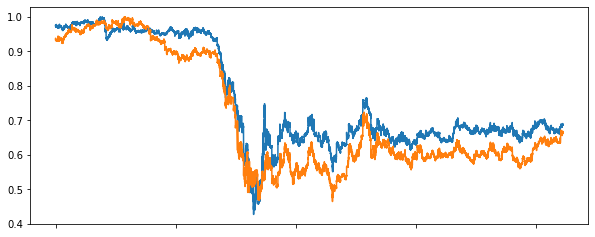

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(series[a] / series[a].max())
plt.plot(series[b] / series[b].max())
plt.xticks(visible=False);

### Analysis

This computation starts out with an embarrassingly parallel part loading data from disk:

```python
series = {}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['x']
```

It follows with a doubly nested for loop with an if statement.  

```python
results = {}

for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
```

It *is* possible to solve this problem with `map`, but it requires some cleverness.  Instead we'll learn `submit`, an interface to start individual function calls asynchronously.

It finishes with a reduction on small data.  We're not going to care about parallelizing this (it's already very fast.)

```python
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
```

### Executor.submit

The `submit` method starts a computation in a separate thread or process and immediately gives us a `Future` object that refers to the result.  At first, the future is pending.  Once the function completes the future is finished. 

We collect the result of the task with the `.result()` method,
which does not return until the results are available.

In [31]:
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)

from time import sleep

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

future = e.submit(slowadd, 1, 2)
future

<Future at 0x26e881db208 state=running>

In [32]:
future.result()

3

### Submit many tasks, receive many futures

Because submit returns immediately we can submit many tasks all at once and they will execute in parallel.

In [33]:
%%time
results = [slowadd(i, i, delay=1) for i in range(10)]

Wall time: 10 s


In [35]:
%%time
futures = [e.submit(slowadd, i, i, delay=1) for i in range(10)]
results = [f.result() for f in futures]

Wall time: 3 s


### Submit different tasks

The virtue of submit is that you can submit different functions and you can perform a bit of logic on each input.

### Exercise: parallelize the following code with e.submit

1.  Replace the `results` list with a list called `futures`
2.  Replace calls to `slowadd` and `slowinc` with `e.submit` calls on those functions
3.  At the end, block on the computation by recreating the `results` list by calling `.result()` on each future in the `futures` list.

In [36]:
%%time

### Sequential Version

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

def slowsub(a, b, delay=1):
    sleep(delay)
    return a - b

results = []
for i in range(5):
    for j in range(5):
        if i < j:
            results.append(slowadd(i, j, delay=1))
        elif i > j:
            results.append(slowsub(i, j, delay=1))

Wall time: 20 s


In [40]:
%%time

### Parallel Version 把任务调价到futures
futures = []
for i in range(5):
    for j in range(5):
        if i < j:
#             注意submit的时候是把函数和参数分别作为submit的参数的
            futures.append(e.submit(slowadd, i, j, delay=1))
        elif i > j:
            futures.append(e.submit(slowsub, i, j, delay=1))
# futures 中结果取出来，用 .result
results = [f.result() for f in futures]

Wall time: 5.01 s


In [39]:
%load solutions/submit-1.py

### Conclusion on submit

*  Submit fires off a single function call in the background, returning a future.  
*  When we combine submit with a single for loop we recover the functionality of map.  
*  When we want to collect our results we replace each of our futures, `f`, with a call to `f.result()`
*  We can combine submit with multiple for loops and other general programming to get something more general than map.


### Exercise: Parallelize pair-wise correlations with `e.submit`


In [43]:
%%time

### Sequential Code

results = {}

for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
results

Wall time: 712 ms


{('..\\data\\json\\afl.h5', '..\\data\\json\\bwa.h5'): 0.5918591029584709,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\hal.h5'): 0.910259887661687,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\hp.h5'): 0.9549201044903431,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\hpq.h5'): 0.7471529916241803,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\ibm.h5'): 0.8449463956086701,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\jbl.h5'): 0.8282240153850632,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\jpm.h5'): 0.9756592115414888,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\luv.h5'): 0.9407068268094191,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\pcg.h5'): 0.210629807682613,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\usb.h5'): 0.9825292035622964,
 ('..\\data\\json\\bwa.h5', '..\\data\\json\\afl.h5'): 0.5918591029584708,
 ('..\\data\\json\\bwa.h5', '..\\data\\json\\hal.h5'): 0.7622587851488899,
 ('..\\data\\json\\bwa.h5', '..\\data\\json\\hp.h5'): 0.4466779792447738,
 ('..\\data\\json\\bwa.h5', '

In [44]:
%%time

### Parallel Code
# pair-wise的操作时，futures要用 {},函数是要重新定义一个外部式的
def corr(a, b):
    return a.corr(b)

futures = {}
for a in filenames:
    for b in filenames:
        if a != b:
#             对于成对内置型函数，和前面的直接函数还是略有区别
            futures[a, b] = e.submit(corr, series[a], series[b])
# result在dict的value里面，用v.result()取出来 
results = {k: v.result() for k,v in futures.items()}
results

Wall time: 442 ms


{('..\\data\\json\\afl.h5', '..\\data\\json\\bwa.h5'): 0.5918591029584709,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\hal.h5'): 0.910259887661687,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\hp.h5'): 0.9549201044903431,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\hpq.h5'): 0.7471529916241803,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\ibm.h5'): 0.8449463956086701,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\jbl.h5'): 0.8282240153850632,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\jpm.h5'): 0.9756592115414888,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\luv.h5'): 0.9407068268094191,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\pcg.h5'): 0.210629807682613,
 ('..\\data\\json\\afl.h5', '..\\data\\json\\usb.h5'): 0.9825292035622964,
 ('..\\data\\json\\bwa.h5', '..\\data\\json\\afl.h5'): 0.5918591029584708,
 ('..\\data\\json\\bwa.h5', '..\\data\\json\\hal.h5'): 0.7622587851488899,
 ('..\\data\\json\\bwa.h5', '..\\data\\json\\hp.h5'): 0.4466779792447738,
 ('..\\data\\json\\bwa.h5', '

In [42]:
%load solutions/submit-2.py

### Exercise: Threads vs Processes

Try the exercise above using Processes vs Threads by replacing `e` with a ProcessPoolExecutor:

#### Before

```python
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)
```

#### After

```python
from concurrent.futures import ProcessPoolExecutor
e = ProcessPoolExecutor(4)
```

How does performance vary?  We'll talk more about the tradeoffs between threads and processes later on in the tutorial.

### Exercise: Break Python by loading the data in parallel

The HDF5 library we use to load our data is not threadsafe and can cause our entire Python session to crash.

In [45]:
%%time
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)

dfs = e.map(pd.read_hdf, filenames)
series = e.map(lambda df: df['close'], dfs)
series = dict(zip(filenames, series))

Wall time: 5.05 s


Conclusion
-----------

*  We learned how `e.submit` can help us to parallelize more complex applications
*  We used `e.submit` to compute pairwise collelations in parallel
*  We learned that this didn't actually speed up our code very much
*  We compared threads against processes to see some performance differences
*  We crashed our Python session by using threads with unsafe code, warning us that parallelism is sometimes dangerous